# 4. Feature engineering - v2

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from utils import save_features, save_dataframes

In [6]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = ROOT / "data"
INTERIM_DATA = DATA / "interim"

In [3]:
X_train = pd.read_parquet(INTERIM_DATA / 'x_train_split.parquet.gzip')
X_val = pd.read_parquet(INTERIM_DATA / 'x_val_split.parquet.gzip')
X_test = pd.read_parquet(INTERIM_DATA / 'x_test_split.parquet.gzip')

In [4]:
DATAFRAMES = [X_train, X_val, X_test]

## Features to build

In [5]:
for df in DATAFRAMES:
    df['tx_amount_log_mean'] = df.groupby('customer_id')['tx_amount_log'].transform('mean')
    df['tx_amount_log_std'] = df.groupby('customer_id')['tx_amount_log'].transform('std')
    df['tx_amount_log_deviates'] = (
        (df['tx_amount_log'] < (df['tx_amount_log_mean'] - df['tx_amount_log_std'])) | 
        (df['tx_amount_log'] > (df['tx_amount_log_mean'] + df['tx_amount_log_std']))
    ).astype(int)

In [6]:
for df in DATAFRAMES:
    df['secs_since_prev_tx'] = (
        df.groupby('customer_id')['tx_datetime']
        .diff()
        .dt.total_seconds()
        .fillna(-1)
    )

In [7]:
for df in DATAFRAMES:
    df['burst_id'] = df.groupby('customer_id')['secs_since_prev_tx'].transform(lambda x: (x > 3600).cumsum())
    df['n_tx_in_burst'] = df.groupby(['customer_id', 'burst_id'])['tx_amount_log'].transform('count')
    df['burst_mean'] = df.groupby('customer_id')['n_tx_in_burst'].transform('mean').fillna(0)
    df['burst_std'] = df.groupby('customer_id')['n_tx_in_burst'].transform('std').fillna(0)
    df['n_trx_per_burst_deviates'] = (
        (df['n_tx_in_burst'] < (df['burst_mean'] - df['burst_std'])) | 
        (df['n_tx_in_burst'] > (df['burst_mean'] + df['burst_std']))
    ).astype(int)

In [8]:
eps = 1e-9

for dif in DATAFRAMES:
    df['zscore'] = df.groupby('customer_id').apply(lambda x: (x['tx_amount_log'] - x['tx_amount_log_mean']) / x['tx_amount_log_std']).to_numpy()
    df['is_zscore_outlier'] = (df['zscore'] > 3).astype(int)
    q1 = df.groupby('customer_id')['tx_amount_log'].transform(lambda s: s.quantile(0.25))
    q3 = df.groupby('customer_id')['tx_amount_log'].transform(lambda s: s.quantile(0.75))
    med = df.groupby('customer_id')['tx_amount_log'].transform('median')
    iqr = (q3 - q1).replace(0, np.nan).fillna(eps)
    df['is_iqr_outlier'] = (~df['tx_amount_log'].between(q1 - 0.5*iqr, q3 + 0.5*iqr)).astype(int)

    df['tx_amount_log_scaled'] = (df['tx_amount_log'] - med) / iqr
    df['is_rs_anomaly'] = (df['tx_amount_log_scaled'].abs() > 1.5).astype(int)

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/2472172343.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['zscore'] = df.groupby('customer_id').apply(lambda x: (x['tx_amount_log'] - x['tx_amount_log_mean']) / x['tx_amount_log_std']).to_numpy()
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/2472172343.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['zscore'] = df.group

In [9]:
for df in DATAFRAMES:
    df['hour_zscore'] = df.groupby('customer_id').apply(lambda x: (x['hour'] - x['hour'].mean()) / x['hour'].std()).to_numpy()
    df['hour_zscore_deviates'] = (df['hour_zscore'].abs() > 2).astype(int)

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/306614127.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['hour_zscore'] = df.groupby('customer_id').apply(lambda x: (x['hour'] - x['hour'].mean()) / x['hour'].std()).to_numpy()
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/306614127.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['hour_zscore'] = df.groupby('customer_id

In [10]:
window = 20
min_periods = 5

for df in DATAFRAMES:
    df['rolling_median'] = df.groupby('customer_id')['tx_amount_log'].rolling(
        window, min_periods=min_periods
    ).median().fillna(0.0).to_numpy()
    df['q1'] = df.groupby('customer_id')['tx_amount_log'].rolling(window, min_periods=min_periods).quantile(0.25).to_numpy()
    df['q3'] = df.groupby('customer_id')['tx_amount_log'].rolling(window, min_periods=min_periods).quantile(0.75).to_numpy()
    df['iqr'] = df['q3'] - df['q1']

    df['amount_robust_rolling20'] = (df['tx_amount_log'] - df['rolling_median']) / (df['iqr'] + eps)

    # если в начале NaN — заполним 0
    df['amount_robust_rolling20'] = df['amount_robust_rolling20'].fillna(0)
    df['is_amount_robust_rolling_outlier'] = (df['amount_robust_rolling20'] > 3).astype(int)

In [11]:
for df in DATAFRAMES:
    mean_ = df.groupby('customer_id')['day_of_week'].transform('mean')
    std_ = df.groupby('customer_id')['day_of_week'].transform('std')
    df['day_of_week_mean'] = mean_.fillna(0)
    df['day_of_week_std'] = std_.fillna(0)
    df['is_day_of_week_mean_outlier'] = (
        (df['day_of_week'] < (df['day_of_week_mean'] - df['day_of_week_std'])) |
        (df['day_of_week'] > (df['day_of_week_mean'] + df['day_of_week_std']))
    ).astype(int)
    df['day_of_week_zscore'] =  df.groupby('customer_id').apply(lambda x: (x['day_of_week'] - x['day_of_week_mean']) / x['day_of_week_std']).to_numpy()
    df['is_day_of_week_zscore_outlier'] = (df['day_of_week_zscore'].abs() > 2).astype(int)

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/933340685.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['day_of_week_zscore'] =  df.groupby('customer_id').apply(lambda x: (x['day_of_week'] - x['day_of_week_mean']) / x['day_of_week_std']).to_numpy()
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_61800/933340685.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['day_of_week_

In [12]:
for i, df in enumerate(DATAFRAMES):
    dfc = df.sort_values(['customer_id','tx_datetime']).reset_index(drop=True).copy()
    dfc['n_tx_in_prev_24h'] = 0
    one_day = np.timedelta64(1, 'D')

    for cid, grp in dfc.groupby('customer_id'):
        t = grp['tx_datetime'].to_numpy('datetime64[ns]')
        left = t - one_day
        j = np.searchsorted(t, left, side='left')
        cnt = np.arange(len(t)) - j
        dfc.loc[grp.index, 'n_tx_in_prev_24h'] = cnt.astype(int)

    g = dfc.groupby('customer_id')
    dfc['q90_prev'] = g['n_tx_in_prev_24h'].transform(
        lambda s: s.shift(1).expanding().quantile(0.90).fillna(0)
    )
    dfc['is_24h_burst'] = (
        dfc['n_tx_in_prev_24h'] >= dfc['q90_prev']
    ).fillna(False).astype(int)
    dfc['is_24h_burst_fixed'] = (dfc['n_tx_in_prev_24h'] >= 3).astype(int)
    dfc['day'] = dfc['tx_datetime'].dt.date
    dg = dfc.groupby(['customer_id','day'])['tx_amount_log']

    day_median = dg.transform('median')
    day_mad = dg.transform(lambda s: (s - s.median()).abs().median())  # MAD
    eps = 1e-9
    dfc['z_in_day_robust'] = (dfc['tx_amount_log'] - day_median) / (1.4826*day_mad + eps)

    # Флаг "аномалия в дне" (подбери порог, обычно 2.0–3.0)
    dfc['is_anomalous_in_day'] = (dfc['z_in_day_robust'].abs() > 2.5).astype(int)
    dfc['fraud_burst_candidate'] = (
        (dfc['is_24h_burst'] == 1) &
        (dfc['z_in_day_robust'] > 1.0)   # подстрой по данным: 1.0–2.0
    ).astype(int)
    DATAFRAMES[i] = dfc

## Save features

In [ ]:
columns = [
    'tx_amount',
    'sector_id',
    'tx_amount_log',
    'hour', 
    'month',
    'is_month_start',
    'is_month_end',
    'is_weekend',
    'tx_amount_log_mean',
    'tx_amount_log_std',
    'tx_amount_log_deviates',
    'secs_since_prev_tx',
    'burst_id',
    'n_tx_in_burst',
    'burst_mean',
    'burst_std',
    'n_trx_per_burst_deviates',
    'hour_zscore',
    'hour_zscore_deviates',
    'rolling_median',
    'q1',
    'q3',
    'iqr',
    'amount_robust_rolling20',
    'is_amount_robust_rolling_outlier',
    'day_of_week_mean',
    'day_of_week_std',
    'is_day_of_week_mean_outlier',
    'day_of_week_zscore',
    'is_day_of_week_zscore_outlier',
    'n_tx_in_prev_24h',
    'q90_prev',
    'is_24h_burst',
    'is_24h_burst_fixed',
    'day_of_week',
    'z_in_day_robust',
    'is_anomalous_in_day',
    'fraud_burst_candidate'
]

In [15]:
X_train, X_val, X_test = DATAFRAMES

In [7]:
save_features(INTERIM_DATA / "features.yaml", columns)

In [17]:
import os

save_dataframes({
    os.path.join(INTERIM_DATA, "x_train_features.parquet.gzip"): X_train,
    os.path.join(INTERIM_DATA,"x_val_features.parquet.gzip"): X_val,
    os.path.join(INTERIM_DATA,"x_test_features.parquet.gzip"): X_test,
})

In [19]:
assert False

AssertionError: 

In [ ]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from utils import (
    pr_at_thresholds,
    cm_for_threshold,
    explain_confusion_matrix
)

In [ ]:
y_train = X_train['tx_fraud']
y_val = X_val['tx_fraud']
y_test = X_test['tx_fraud']

In [1]:
columns = [
    'tx_amount',
    'sector_id',
    'tx_amount_log', 
    'ones',
    'hour', 
    'month',
    'is_month_start',
    'is_month_end',
    'is_weekend',
    'tx_amount_log_mean',
    'tx_amount_log_std',
    'tx_amount_log_deviates',
    'secs_since_prev_tx',
    'burst_id',
    'n_tx_in_burst',
    'burst_mean',
    'burst_std',
    'n_trx_per_burst_deviates',
    'hour_zscore',
    'hour_zscore_deviates',
    'rolling_median',
    'q1',
    'q3',
    'iqr',
    'amount_robust_rolling20',
    'is_amount_robust_rolling_outlier',
    'day_of_week_mean',
    'day_of_week_std',
    'is_day_of_week_mean_outlier',
    'day_of_week_zscore',
    'is_day_of_week_zscore_outlier',
    'n_tx_in_prev_24h',
    'q90_prev',
    'is_24h_burst',
    'is_24h_burst_fixed',
    'day_of_week',
    'z_in_day_robust',
    'is_anomalous_in_day',
    'fraud_burst_candidate'
]

## Correlations

In [ ]:
corr = X_train[columns].corr(method='pearson')

In [ ]:
corr_abs = corr.abs()
high_corr = corr_abs.unstack().sort_values(ascending=False)
high_corr = high_corr[(high_corr < 1) & (high_corr > 0.97)]

In [ ]:
high_corr

Series([], dtype: float64)

In [ ]:
import networkx as nx

pairs = [tuple(sorted(k)) for k in high_corr.keys()]
G = nx.Graph()
G.add_edges_from(pairs)

groups = list(nx.connected_components(G))
print(f"Found {len(groups)} correlated groups")

Found 3 correlated groups


In [ ]:
columns_to_delete = []
for gr in groups:
    columns_to_delete.extend(sorted(gr)[1:])

columns_to_delete

['q3',
 'rolling_median',
 'tx_amount_log',
 'tx_amount_log_mean',
 'hour_zscore',
 'day_of_week_zscore']

In [ ]:
print(f"Overall features count: {len(set(columns))}")
print(f"Columns to delete (due to high correlation) count: {len(set(columns_to_delete))}")

Overall features count: 39
Columns to delete (due to high correlation) count: 6


In [ ]:
columns = list(set(columns) - set(columns_to_delete))

## Train model

* Before feature validation (correlation):
    * ROC AUC: 0.985
    * PR AUC:  0.593
* After feature validation:
    * ROC AUC: 0.985
    * PR AUC:  0.590

In [ ]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

best_params = {
 'max_depth': 11,
 'subsample': 0.9,
 'n_estimators': 2300,
 'eta': 0.08,
 'reg_alpha': 14,
 'reg_lambda': 7,
 'min_child_weight': 19,
 'colsample_bytree': 0.8946111526982555
}
model = XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method='hist', 
    gpu_id=0, 
    predictor="cpu_predictor",
    **best_params
)
model.fit(
    X_train[columns], y_train,
    eval_set=[(X_val[columns], y_val)], 
    verbose=False
)
y_xgb_predict_proba = model.predict_proba(X_test[columns])[:, 1]
roc_auc = roc_auc_score(y_test, y_xgb_predict_proba)
pr_auc = average_precision_score(y_test, y_xgb_predict_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC:  {pr_auc:.3f}")

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.985
PR AUC:  0.593


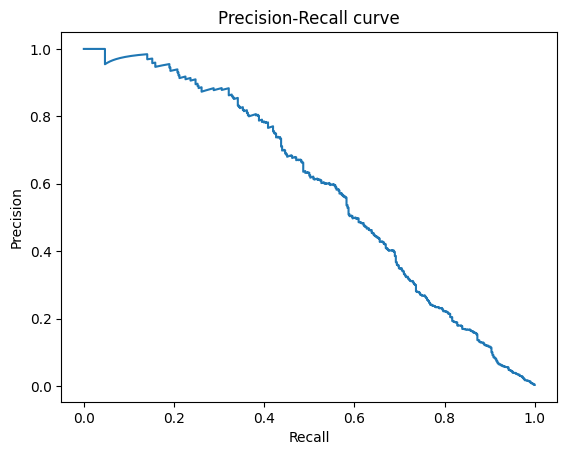

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_xgb_predict_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [ ]:
grid = np.sort(np.unique(np.round(y_xgb_predict_proba, 3)))
rows = []

for t in sorted(set(grid)):
    y_hat = (y_xgb_predict_proba >= t).astype(int)
    
    pr = precision_score(y_test, y_hat, zero_division=0)
    rc = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    f05 = fbeta_score(y_test, y_hat, beta=0.5, zero_division=0)
    f2 = fbeta_score(y_test, y_hat, beta=2, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    fp_rate = fp / (fp + tn)
    
    rows.append((t, pr, rc, f1, f05, f2, tp, fp, fn, tn, fp_rate))

grid_df = pd.DataFrame(
    rows,
    columns=['thr', 'precision', 'recall', 'f1', 'f0.5', 'f2', 'TP', 'FP', 'FN', 'TN', 'fp_rate']
).sort_values('thr')

In [ ]:
grid_df

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
0,0.000,0.003227,1.000000,0.006432,0.004030,0.015927,448,138399,0,0,1.000000
1,0.001,0.034761,0.962054,0.067097,0.043062,0.151857,431,11968,17,126431,0.086475
2,0.002,0.050220,0.941964,0.095356,0.061950,0.206964,422,7981,26,130418,0.057667
3,0.003,0.062472,0.924107,0.117032,0.076792,0.245872,414,6213,34,132186,0.044892
4,0.004,0.072143,0.917411,0.133767,0.088440,0.274402,411,5286,37,133113,0.038194
...,...,...,...,...,...,...,...,...,...,...,...
675,0.996,0.938144,0.203125,0.333945,0.544258,0.240868,91,6,357,138393,0.000043
676,0.997,0.954545,0.187500,0.313433,0.525000,0.223404,84,4,364,138395,0.000029
677,0.998,0.948718,0.165179,0.281369,0.486842,0.197861,74,4,374,138395,0.000029
678,0.999,0.982456,0.125000,0.221782,0.414201,0.151433,56,1,392,138398,0.000007


In [ ]:
grid_df[grid_df['f1'] == grid_df['f1'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
485,0.681,0.595238,0.558036,0.576037,0.587406,0.565099,250,170,198,138229,0.001228


In [ ]:
grid_df[grid_df['f0.5'] == grid_df['f0.5'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
633,0.95,0.801843,0.388393,0.523308,0.661094,0.433051,174,43,274,138356,0.000311


In [ ]:
grid_df[grid_df['f2'] == grid_df['f2'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
250,0.272,0.398196,0.689732,0.504902,0.434966,0.601636,309,467,139,137932,0.003374


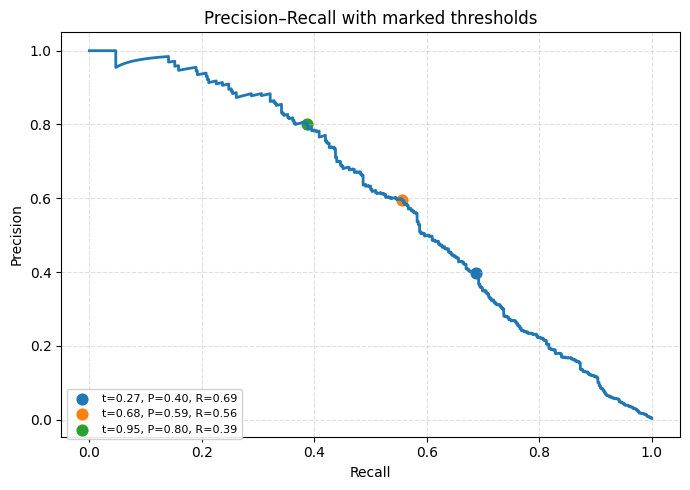

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(recall, precision, lw=2)

mark_thrs = [0.272, 0.681, 0.95]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles=[]
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc='lower left')

ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
from utils import (
    pr_at_thresholds,
    cm_for_threshold,
    explain_confusion_matrix
)

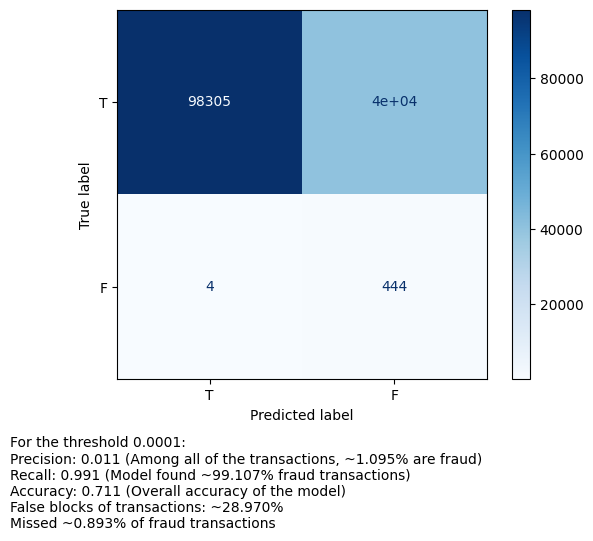

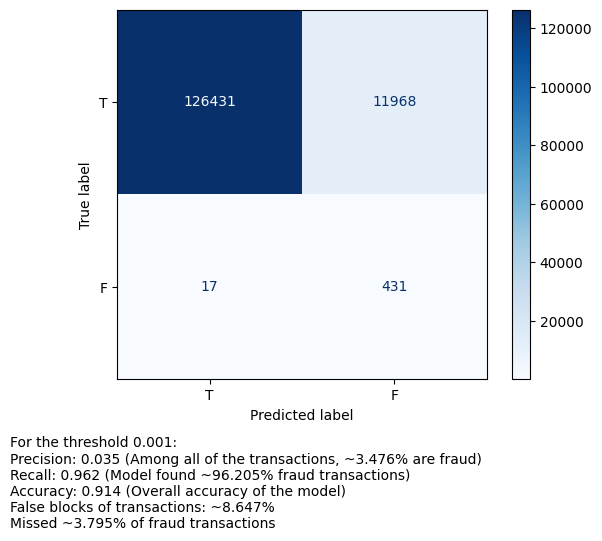

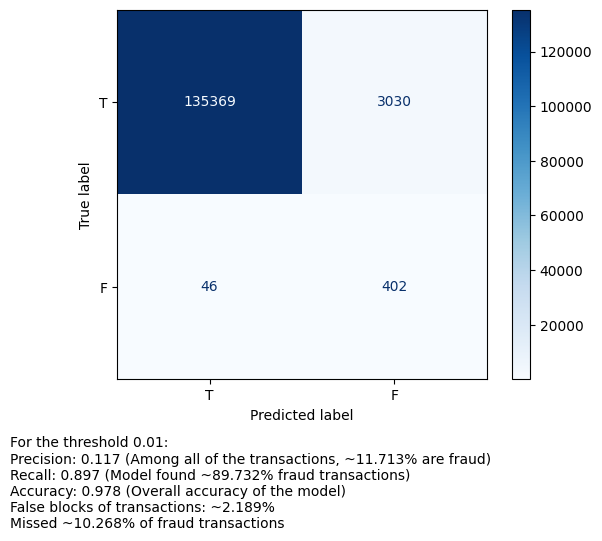

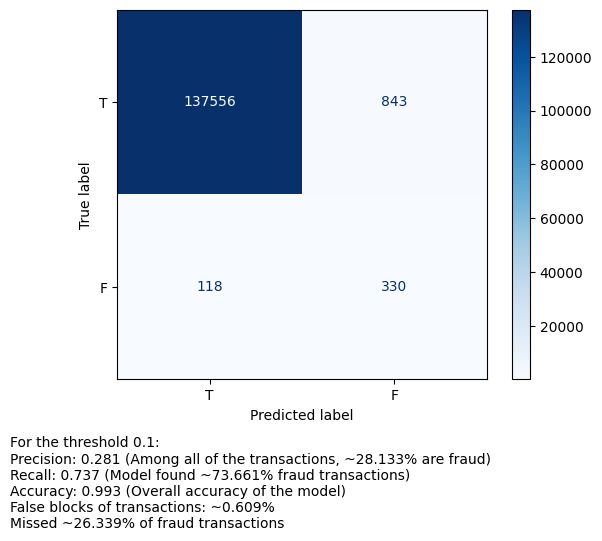

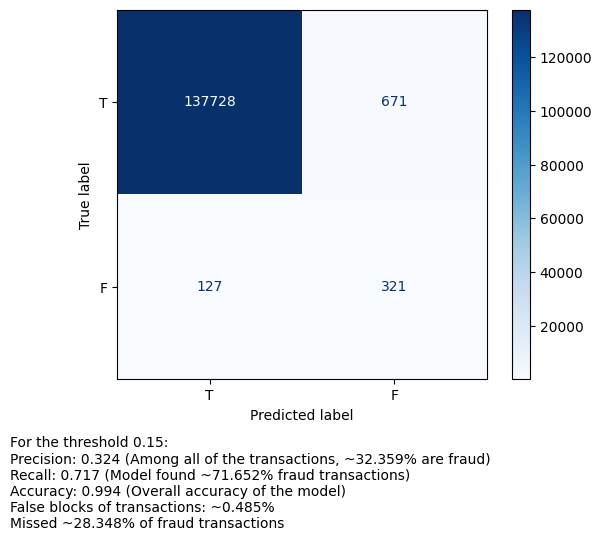

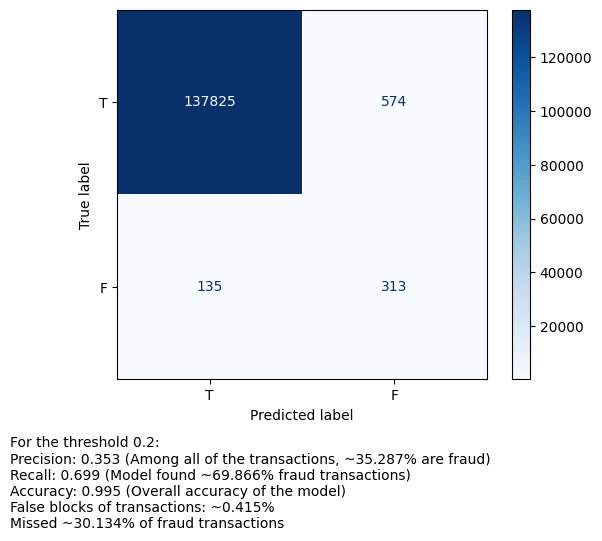

In [ ]:
for thr in [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2]:
    conf_matrix = cm_for_threshold(thr, y_xgb_predict_proba, y_test)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['T', 'F'])
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))